# Material Balances XVII

This lecture solves reactor design problems involving semi-batch reactors; membrane reactors; recycle reactors, and packed beds with pressure drops.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

## Example Problem 01

The synthesis of Methyl Bromide is carried out in the liquid phase using a well-mixed tank reactor. 
			
$$C\!N\!Br + C\!H_3N\!H_2 \longrightarrow C\!H_3Br + N\!C\!N\!H_2$$

The tank is initially filled with 5L of a solvent solution containing Bromine Cyanide (A) at a concentration of 0.05M.  At time zero, you turn on the feed to the reactor, which is a solvent solution containing methylamine (B) at 0.025M; the feed enters the reactor at a total volumetric flowrate of 0.05 L s$^{-1}$. This reaction is first order in A and first order in B, and we are given a rate constant of:

$$k = 2.2 \ \textrm{L} \ \textrm{mol}^{-1} \ \textrm{s}^{-1}$$

All species are dissolved in an inert solvent and present at relatively low concentrations, so we can assume that the density of all fluid in the system is approximately equal to the density of the solvent. Plot the concentrations of all species in the reactor as well as the rate of reaction as a function of time.

### Solution to Example Problem 01

We'll use the shorthand:

$$A + B \longrightarrow C + D$$

Write balances on species:

\begin{align}
    \frac{dN_A}{dt} &= R_AV \\
    \frac{dN_B}{dt} &= F_{Bf} + R_BV \\
    \frac{dN_C}{dt} &= R_CV \\
    \frac{dN_D}{dt} &= R_DV
\end{align}

The only new concept above is that, for species B, we have an inlet molar flowrate, so that (with respect to species B), this looks like a transient CSTR balance with no outflow. We can calculate the value of the feed molar flowrate of B using information in the problem statement:

$$F_{Bf} = C_{Bf}Q_f$$

Define Production rates $R_j$:

\begin{align}
    R_A &= -r \\
    R_B &= -r \\
    R_C &= r \\
    R_D &= r
\end{align}

Reaction rate is given by:

$$r = kC_AC_B$$

Concentrations are given by:

\begin{align}
    C_A = \frac{N_A}{V} \\
    C_B = \frac{N_B}{V}
\end{align}

Volume is clearly not going to be constant in this reactor since we have an inlet flow and no outlet flow.  We aren't given densities or molecular weights for these species, but we're told that the density is constant.  This makes it relatively easy to derive an equation that describes the change in volume with time.  Starting with a total mass balance:

$$\frac{dm}{dt} = \dot{m}_{f}$$

We can express mass ($m$) and mass flowrate ($\dot{m}_{f}$) in terms of volume ($V$), volumetric flowrate ($Q_f$), and density ($\rho$):

$$\frac{d(\rho V)}{dt} = \rho Q_f$$

Since density is time invariant in this problem, the ODE simplifies to:

$$\frac{dV}{dt} = Q_f$$

This can be solved analytically since it is not coupled to any other time dependent terms to give:

$$V = V_0 + Q_ft$$

Alternatively, you can use `solve_ivp()` to integrated the volume differential equation alongside the material balances.  This approach is more general, so we'll use that one to solve this problem.

In [2]:
V0  = 5.0 #L
CA0 = 0.05 #mol/L
Qf  = 0.05 #L/s
CBf = 0.025 #mol/L
FBf = CBf*Qf

NA0 = CA0*V0
NB0 = 0.0
NC0 = 0.0
ND0 = 0.0
k   = 2.2  #L/mol/s

In [3]:
def P01(t, var, par):
    
    NA, NB, NC, ND, V = var
    k, Qf = par
    
    CA = NA/V
    CB = NB/V
    
    r  = k*CA*CB
    
    RA = -r
    RB = -r
    RC =  r
    RD =  r
    
    D1 =       RA*V
    D2 = FBf + RB*V
    D3 =       RC*V
    D4 =       RD*V
    D5 = Qf
    
    return [D1, D2, D3, D4, D5]

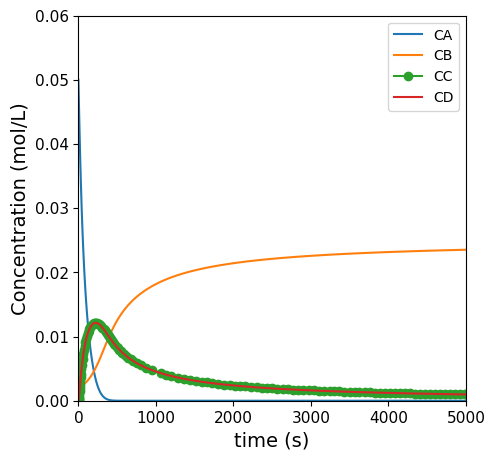

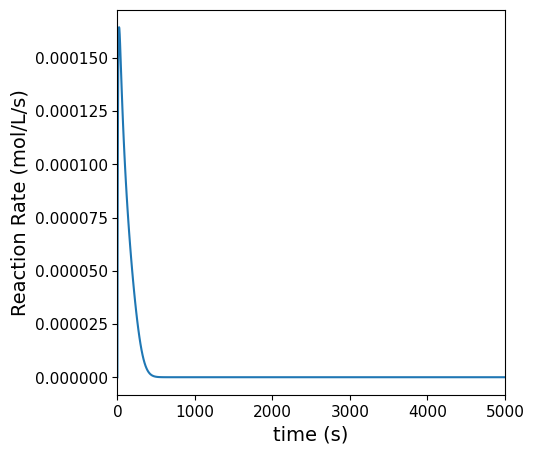

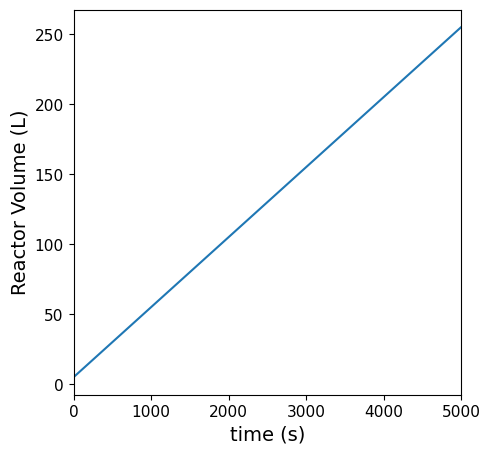

In [4]:
tspan = (0.0, 5000.0)
var0  = (NA0, NB0, NC0, ND0, V0)
par0  = (k, Qf)
ans1  = solve_ivp(P01, tspan, var0, args = (par0, ), atol = 1e-8, rtol = 1e-8)

t     = ans1.t
NA    = ans1.y[0, :]
NB    = ans1.y[1, :]
NC    = ans1.y[2, :]
ND    = ans1.y[3, :]
V     = ans1.y[4, :]

CA    = NA/V
CB    = NB/V
CC    = NC/V
CD    = ND/V
r     = k*CA*CB

plt.figure(1, figsize = (5, 5))
plt.plot(t, CA, label = 'CA')
plt.plot(t, CB, label = 'CB')
plt.plot(t, CC, marker = 'o', label = 'CC')
plt.plot(t, CD, label = 'CD')
plt.xlim(0.0, max(tspan))
plt.xticks(fontsize = 11)
plt.xlabel('time (s)', fontsize = 14)
plt.ylim(0.0, 0.06)
plt.yticks(fontsize = 11)
plt.ylabel('Concentration (mol/L)', fontsize = 14)
plt.legend()
plt.show(1)

plt.figure(2, figsize = (5, 5))
plt.plot(t, r)
plt.xlim(0.0, max(tspan))
plt.xticks(fontsize = 11)
plt.xlabel('time (s)', fontsize = 14)
#plt.ylim(0.0, 0.06)
plt.yticks(fontsize = 11)
plt.ylabel('Reaction Rate (mol/L/s)', fontsize = 14)
plt.show(2)


plt.figure(3, figsize = (5, 5))
plt.plot(t, V)
plt.xlim(0.0, max(tspan))
plt.xticks(fontsize = 11)
plt.xlabel('time (s)', fontsize = 14)
#plt.ylim(0.0, 10)
plt.yticks(fontsize = 11)
plt.ylabel('Reactor Volume (L)', fontsize = 14)
plt.show(3)

## Example Problem 02

You are designing a flow reactor in order to perform gas-phase propane dehydrogenation.  The purpose of this reaction is "on purpose" generation of propylene, which has historically been produced as a side product of ethylene synthesis via naphtha cracking. One of the consequences of the shale gas boom is that it greatly expanded the supply of ethane (and thus decrease the cost of ethane).  Accordingly, the majority of our ethylene production has shifted to ethane pyrolysis, which does not produce significant quantities of propylene.  Hence your interest in an on-purpose synthesis of propylene!
			
$$C_3H_8 \longleftrightarrow C_3H_6 + H_2$$

The reaction has an elementary rate law, and it is performed at 500K and 8.2atm.  At this temperature, you find that the forward rate constant and the concentration-based equilibrium constant are:

\begin{align*}
    k_f  = 0.7  \ \textrm{min}^{-1} \\
    K_C = 0.05 \ \textrm{mol} \ \textrm{L}^{-1}				
\end{align*}			

If the feed rate of propane to the reactor is 10 moles per minute, find the PFR volume required to achieve 95\% conversion.

### Solution to Example Problem 02

#### Material Balances

Our instinct for solving this problem is to write a balance on each species:

$$\frac{dF_j}{dV} = R_j$$

We can then specify a production rate for each species in terms of the reaction rate:

$$R_j = \sum_i \nu_{i,j}r_i$$

The reaction rate in this problem is elementary, so:

$$r = k_fC_A - k_rC_BC_C$$

And we can define concentrations in terms of flowrates:

$$C_j = \frac{F_j}{Q}$$

Where Q is given by:

$$Q = \frac{F_T RT}{P}$$

In terms of parameters, we are given $k_f$, $T$, $P$, and $F_{Af}$.  We can infer that $F_{Bf}$ and $F_{Cf}$ are both zero.  Finally, we can calculate the reverse rate constant:

$$k_r = \frac{k_f}{K_C}$$

With this, we can solve the problem by integrating the coupled ODEs with `solve_ivp()` and using `interp1D()` to back out the volume where we hit our conversion target.

In [5]:
kf = 0.7  #1/min
KC = 0.05 #mol/L
kr = kf/KC #L/mol/min
T  = 500 #K
P  = 8.2 #atm
R  = 0.08206 #L*atm/mol/K
FAf = 10.0 #mol/min
FBf = 0.0
FCf = 0.0
XA_target = 0.95

In [6]:
def P02(V, var, par):
    FA, FB, FC = var
    kf, kr, T, P, R = par
    
    FT = FA + FB + FC
    
    Q  = FT*R*T/P
    
    CA = FA/Q
    CB = FB/Q
    CC = FC/Q
    
    r  = kf*CA - kr*CB*CC
    
    RA = -r
    RB =  r
    RC =  r
    
    dA = RA
    dB = RB
    dC = RC
    
    return [dA, dB, dC]

In [7]:
Vspan = (0.0, 10.0)
var0  = (FAf, FBf, FCf)
par0  = (kf, kr, T, P, R)
ans2  = solve_ivp(P02, Vspan, var0, args = (par0, ), atol = 1e-8, rtol =  1e-8)

V     = ans2.t
FA    = ans2.y[0, :]
FB    = ans2.y[1, :]
FC    = ans2.y[2, :]

XA    = (FAf - FA)/FAf
itp1 = interp1d(XA, V)
itp1(XA_target)

# plt.figure(1, figsize = (5, 5))
# plt.plot(V, XA)
# plt.xlim(0.0, max(Vspan))
# plt.xticks(fontsize = 11)
# plt.xlabel('Volume (L)', fontsize = 14)
# plt.ylim(0.0, 1.0)
# plt.yticks(fontsize = 11)
# plt.ylabel('Conversion of A', fontsize = 14)
# plt.show(1)

ValueError: A value (0.95) in x_new is above the interpolation range's maximum value (0.12099110341844846).

#### Always assess equilibrium limits for reversible reactions!

We failed to consider the equilibrium limit before we asked for 95% conversion.  If we solve the equilibrium problem, we can see how attainable conversion depends on the specifications for this problem.  The best way to solve this is using the methods from Unit 02, where we solve an algebraic equation given by:

$$K_C - \prod_j C_j^{\nu_j} = 0$$

To do so, we can develop a mole table that relates all species flowrates to fractional conversion.

In [11]:
def eqns2a(XA, par):
    
    KC, T, P, R, FAf, FBf, FCf = par
    
    FA = FAf - FAf*XA
    FB = FBf + FAf*XA
    FC = FCf + FAf*XA
    FT = FA + FB + FC
    
    Q  = FT*R*T/P
    
    CA = FA/Q
    CB = FB/Q
    CC = FC/Q
        
    KC_comp = CC*CB/CA
    
    eqn1    = KC_comp - KC
    return eqn1

In [12]:
XAguess = 0.7
par0    = KC, T, P, R, FAf, FBf, FCf
ans3    = opt.newton(eqns2a, XAguess, args = (par0, ))
ans3

0.4473444489882259

#### Increasing the attainable equilibrium conversion

From the above analysis of equilibrium limits for these conditions, we learn that it is impossible to attain the requested conversion under the given conditions. Since this is a reaction where the number of moles increase with reaction (assuming we do not change the temperature), the only way we can improve the equilibrium limit so that we can reach the requested 95% conversion is to either reduce the system pressure, add an inert gas diluent (which accomplishes the same thing as reducing the pressure in terms of the equilibrium analysis), or do some combination of the two if it is more practical. 

We adapt the equilibrium problem below by adding diluent and reducing the operating pressure.

In [13]:
def eqns2b(XA, par):
    
    KC, T, P, R, FAf, FBf, FCf, FIf = par
    
    FA = FAf - FAf*XA
    FB = FBf + FAf*XA
    FC = FCf + FAf*XA
    FI = FIf
    FT = FA + FB + FC + FI
    
    Q  = FT*R*T/P
    
    CA = FA/Q
    CB = FB/Q
    CC = FC/Q
        
    KC_comp = CC*CB/CA
    
    eqn1    = KC_comp - KC
    return eqn1

In [14]:
Pb  = 8.2 #atm
R  = 0.08206 #L*atm/mol/K
FAfb = 10.0 #mol/min
FBfb = 0.0
FCfb = 0.0
FIfb = 0.0 #mol/min
XA_target = 0.95

In [15]:
XAguess = 0.95
par0    = KC, T, Pb, R, FAfb, FBfb, FCfb, FIfb
ans3    = opt.newton(eqns2b, XAguess, args = (par0, ))
ans3

0.44734444898825954

#### Returning to the material balances under conditions where we can reach 95% conversion

Next, we re-solve the material balances with conditions where it will be possible to reach 95% conversion to solve for the required reactor volume.  Specifically, we reduce the system pressure to 1 atm, and we add a diluent (e.g., $N_2$ gas) to the feed stream at 100 moles per minute.

In [16]:
def P02b(V, var, par):
    FA, FB, FC = var
    kf, kr, T, P, R, FIf = par
    FI = FIf
    
    FT = FA + FB + FC + FI
    
    Q  = FT*R*T/P
    
    CA = FA/Q
    CB = FB/Q
    CC = FC/Q
    
    r  = kf*CA - kr*CB*CC
    
    RA = -r
    RB =  r
    RC =  r
    
    dA = RA
    dB = RB
    dC = RC
    
    return [dA, dB, dC]

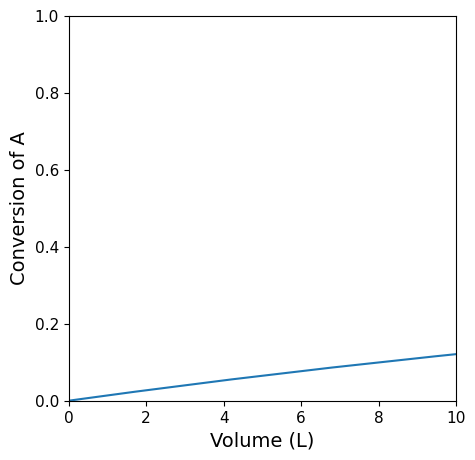

ValueError: A value (0.95) in x_new is above the interpolation range's maximum value (0.12099110341844846).

In [19]:
Vspan = (0.0, 10.0)
var0  = (FAfb, FBfb, FCfb)
par0  = (kf, kr, T, Pb, R, FIfb)
ans2  = solve_ivp(P02b, Vspan, var0, args = (par0, ), atol = 1e-8, rtol =  1e-8)

V     = ans2.t
FA    = ans2.y[0, :]
FB    = ans2.y[1, :]
FC    = ans2.y[2, :]

XA    = (FAf - FA)/FAf

plt.figure(1, figsize = (5, 5))
plt.plot(V, XA)
plt.xlim(0.0, max(Vspan))
plt.xticks(fontsize = 11)
plt.xlabel('Volume (L)', fontsize = 14)
plt.ylim(0.0, 1.0)
plt.yticks(fontsize = 11)
plt.ylabel('Conversion of A', fontsize = 14)
plt.show(1)

itp1 = interp1d(XA, V, kind = 'cubic')
Vopt = itp1(XA_target)
print(f'The Volume required for XA = {XA_target:0.2f} is {Vopt:0.0f}L')

## Example Problem 03

**Note: Relabel flowrates FA0 through FA5 to be consistent with recitation; figures are in folder in GitHub**

**Propylene Dehydrogenation with separation and recycle**

An alternative approach is to use a recycle strategy.  Specifically, we will operate the reactor at a relatively low single pass conversion, but we will recycle a fraction of the unreacted propane back to the reactor inlet.  This allows us to achieve a higher overall conversion in the process even though we have a relatively low limit on the single pass conversion through the reactor. 

We will assume a very simple PFD here:  The propane feed into the process is combined with the recycle stream in a mixer; the combined feed goes into a PFR, where it is partially converted to H$_2$ and propylene; the effluent from the reactor goes into a separator, where we assume propane is perfectly separated from H$_2$ and propylene; and, finally, the unreacted propane enters a splitter, where a fraction of it $(\alpha)$ is recycled back to the mixer, and the remaining quantity exits the process.  This is illustrated below:

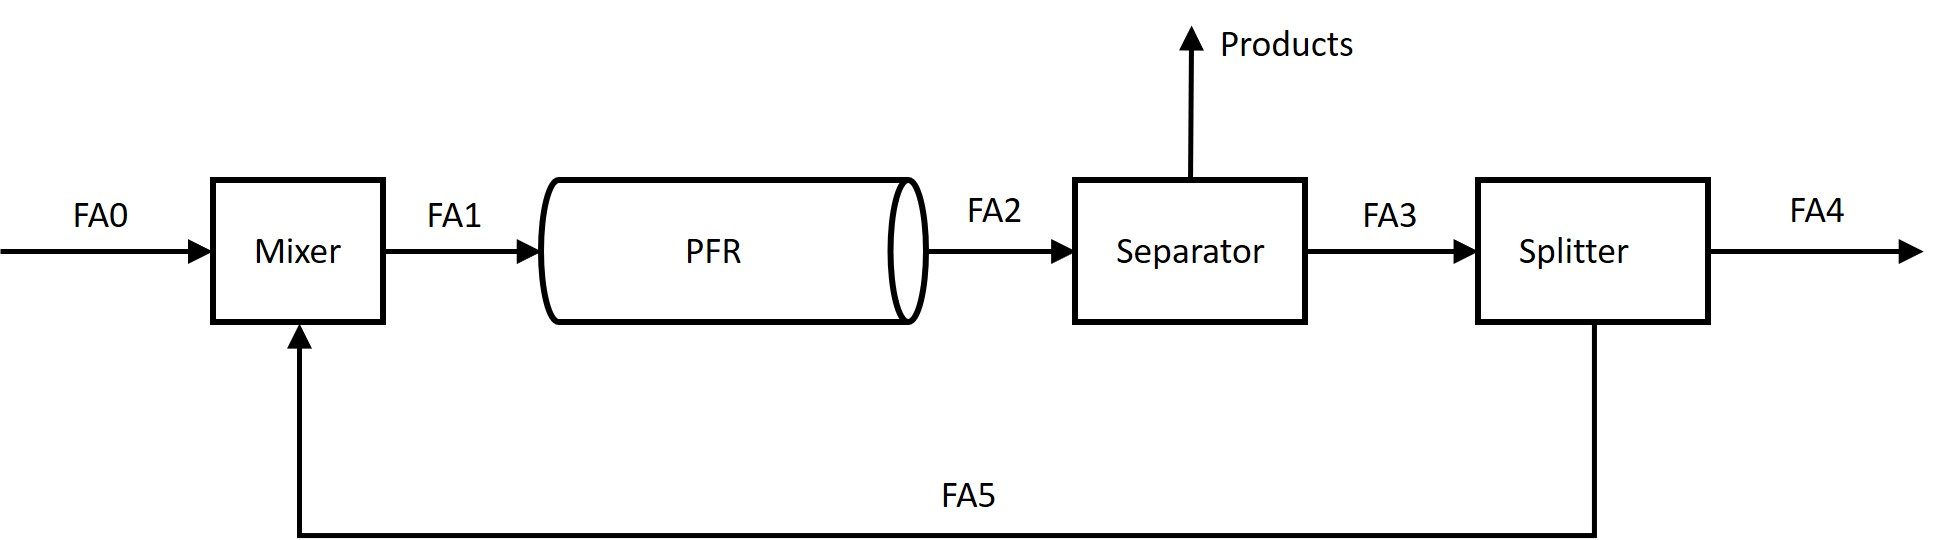

Rate and equilibrium constants remain the same because we haven't changed the temperature, and the propane feed to the entire process remains 10 moles per minute. We will re-set our system pressure to 8.2 atm to gain the benefit in reaction rate.

\begin{align*}
k_f  &= 0.7  \ \textrm{min}^{-1} \\
K_C &= 0.05 \ \textrm{mol} \ \textrm{L}^{-1}\\	
\end{align*}			

1. Find the minimum recycle ratio required to achieve an overall conversion of 95\% in the process described above
2. For that recycle ratio, calculate the reactor volume required to achieve an overall conversion of 95\% in this process

### Solution to Example Problem 03

The most intuitive approach to this problem is to write material balances on all unit operations.  We'll start by writing balances on species A (propane) and go from there...I find it easiest to start with a balance on the overall process and on the splitter for this problem:

#### Analysis of the overall process

If we draw a black box around the whole process, we know that it must achieve 95% conversion of the propane fed into the process at a flowrate of 10 mol/min.  We can therefore define the exit flowrate of propane in terms of the inlet flowrate and the overall conversion

$$F_{A4} = F_{A0}\left(1 - X_{A_{ov}}\right)$$

#### Analysis of the Splitter

A balance on the splitter gives:

$$0 = F_{A3} - F_{A4} - F_{A5}$$

We can express the recycle flowrate as a fraction of the flow into the splitter, i.e., 

$$F_{A5} = \alpha F_{A3}$$

Substituting this into the splitter balance, we find:

$$0 = F_{A3} - F_{A4} - \alpha F_{A3}$$

We can solve for $F_{A3}$ to find:

$$F_{A3} = \frac{1}{1 - \alpha}F_{A4}$$

And we can substitute this back into the definition for $F_{A5}$:

$$F_{A5} = \frac{\alpha}{1 - \alpha} F_{A4}$$

#### Analysis of the separator

A balance on the separator is straightforward and tells us that:

$$F_{A2} = F_{A3}$$

#### Analysis of the mixer

A balance on the mixer will give us the combined feed rate into the reactor, $F_{A0}$

$$F_{A1} = F_{A0} + F_{A5}$$

#### Analysis of the reactor 

If we look at the reactor, we can define a single pass fractional conversion in terms of $F_{A1}$ and $F_{A2}$:

$$X_{SP} = \frac{F_{A1} - F_{A2}}{F_{A1}}$$

We still have a degree of freedom in this system, so we can't solve it just yet.  But, once we specify the recycle ratio, we can fully solve for all flowrates and the single pass conversion through the PFR. The way I'm approaching the analysis here is that we know the equilibrium limit on this PFR at 500K and 8.2 atm is ~ 44% conversion, so we just have to find a recycle ratio that will allow us to operate with a PFR below 44% conversion.

There are numerous other ways we can spec the problem, but this one allows for a straightforward analysis of the recycle situation.  We'll consider more complex recycle examples in Recitation 09.

In [20]:
α   = 0.96
XOV = 0.95
FA0 = 10 #mol/min
FA4 = FA0*(1 - XOV)
FA3 = FA4/(1 - α)
FA2 = FA3
FA5 = α*FA3
FA1 = FA0 + FA5
XSP = (FA1 - FA2)/FA1

labels = ['α', 'FA0', 'FA1', 'FA2', 'FA3', 'FA4', 'FA5', 'XSP', 'XOV']
values = [α, FA0, FA1, FA2, FA3, FA4, FA5, XSP, XOV]

for label, value in zip(labels, values):
    if label != 'XSP' and label != 'XOV':
        print(f'{label:3s} = {value:5.2f} mol/min')
    else:
        print(f'{label:s} = {value:5.2f}')

α   =  0.96 mol/min
FA0 = 10.00 mol/min
FA1 = 22.00 mol/min
FA2 = 12.50 mol/min
FA3 = 12.50 mol/min
FA4 =  0.50 mol/min
FA5 = 12.00 mol/min
XSP =  0.43
XOV =  0.95


#### Solve the Material Balance for a lower target single pass conversion

Once we know the recycle ratio, we can solve for the flowrate and determine the reactor size required to achieve the necessary single pass conversion

In [21]:
# def P02(V, var, par):
#     FA, FB, FC = var
#     kf, kr, T, P, R = par
    
#     FT = FA + FB + FC
    
#     Q  = FT*R*T/P
    
#     CA = FA/Q
#     CB = FB/Q
#     CC = FC/Q
    
#     r  = kf*CA - kr*CB*CC
    
#     RA = -r
#     RB =  r
#     RC =  r
    
#     dA = RA
#     dB = RB
#     dC = RC
    
#     return [dA, dB, dC]

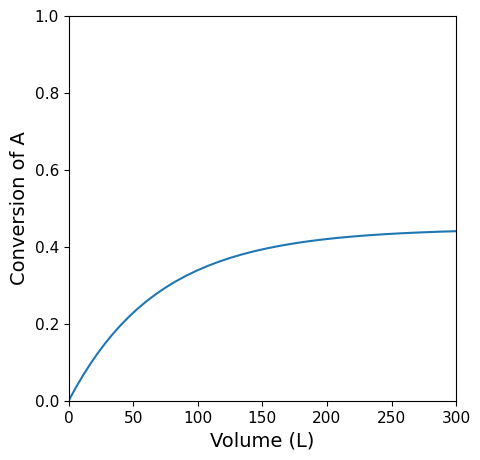

In [22]:
P   = 8.2 #atm
R   = 0.08206 #L*atm/mol/K
FAf = FA1 #mol/min
FBf = 0.0
FCf = 0.0
Vspan = (0.0, 300.0)
var0  = (FAf, FBf, FCf)
par0  = (kf, kr, T, P, R)
ans2  = solve_ivp(P02, Vspan, var0, args = (par0, ), atol = 1e-8, rtol =  1e-8)

V     = ans2.t
FA    = ans2.y[0, :]
FB    = ans2.y[1, :]
FC    = ans2.y[2, :]

XA    = (FAf - FA)/FAf

plt.figure(1, figsize = (5, 5))
plt.plot(V, XA)
plt.xlim(0.0, max(Vspan))
plt.xticks(fontsize = 11)
plt.xlabel('Volume (L)', fontsize = 14)
plt.ylim(0.0, 1.0)
plt.yticks(fontsize = 11)
plt.ylabel('Conversion of A', fontsize = 14)
plt.show(1)

In [23]:
itp1 = interp1d(XA, V)
print(f'The Volume required for a PFR single pass conversion of XA = {XSP:0.2f} is {itp1(XSP):0.0f}L')

The Volume required for a PFR single pass conversion of XA = 0.43 is 242L
